# 😎 Matrix Factorization of Movie Recommendation System with Shrinkage Dataset 20M MovieLens Dataset with help of Apache Spark and Pyspark

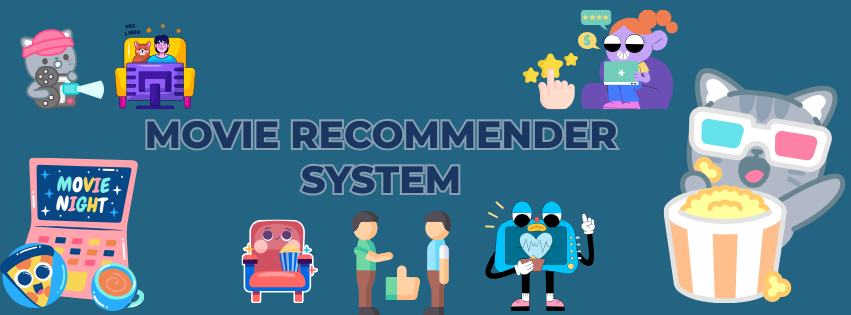

### PySpark 🐍
PySpark is the Python API for Apache Spark, a fast and general-purpose cluster computing system for Big Data processing. It provides a simple and consistent interface for distributed data processing using Python.

### RDD (Resilient Distributed Dataset) 🚀
RDD is a core data structure in PySpark representing an immutable, distributed collection of objects. It enables parallel processing, fault tolerance, and high-level abstractions for distributed data processing.

1. Purpose: RDDs facilitate distributed data processing across a cluster of machines, ensuring fault tolerance and providing a high-level abstraction for complex operations.
2. Benefits:
- Parallel Processing: Enables parallel computation across multiple nodes, improving performance and scalability.
- Fault Tolerance: Automatic recovery from node failures ensures data integrity and reliability.
- Data Immutability: Immutable nature simplifies parallel processing and ensures data consistency.
- Lazy Evaluation: Lazy evaluation reduces unnecessary computation and optimizes performance.
- Versatility: Supports various operations like map, reduce, filter, and join for diverse data processing tasks.

### Summary 🌟
PySpark, with its RDDs, empowers developers to efficiently process large-scale datasets in distributed environments. 🚀 It offers fault tolerance, scalability, and a versatile set of operations, making it a go-to choice for Big Data processing with Python. 🐍💻


### Recommender System 🎯📊: 
A software tool or algorithm that analyzes user preferences and behavior to make personalized recommendations for items or content. Recommender systems aim to assist users in finding relevant items of interest, such as movies, products, or articles, by leveraging techniques like collaborative filtering, content-based filtering, or hybrid methods. These systems are widely used in various domains, including e-commerce, streaming services, social media, and online platforms, to enhance user experience and engagement.

### Collaborative Filtering 🤝🔍: 
Recommender system technique based on users' past interactions to predict their future preferences without requiring explicit knowledge about users or items.

### Matrix Factorization ⚙️🔢: 
Mathematical technique that decomposes a matrix into lower-dimensional matrices, often used in recommendation systems to represent users and items as latent factors.

### Alternating Least Squares (ALS) 🔄➕🔲: 
Matrix factorization algorithm commonly used in collaborative filtering recommender systems. It iteratively updates user and item factors to minimize the squared error between observed and predicted ratings.

### Relationship 💡🔄💡:
Collaborative filtering utilizes user-item interactions for recommendations.
Matrix factorization techniques like ALS decompose interaction matrices to capture latent factors.
ALS is a specific algorithm for collaborative filtering, implementing matrix factorization with alternating least squares optimization.
In essence, collaborative filtering leverages user preferences, matrix factorization captures latent factors, and ALS optimizes this process for making recommendations.

# About Dataset
**📊 Context:** The Original dataset encompasses user ratings and free-text tagging from MovieLens, a movie recommendation platform. It comprises 20,002,263 ratings and 465,564 tag applications across 27,278 movies.

**😆 Shrinking Dataset**
Since the dataset is too large to compute resulted will be O(N^2M), we need to perform shrinking by choosing the users who like maximum number of movies.We selects the top 10,000 users and perform Matrix Factorization.

ref code: https://www.kaggle.com/code/shiblinomani/recommender-system-using-movielens-20m-dataset


In [30]:
import os
import sys
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

In [31]:
# pyspark: Main PySpark library providing functionalities for distributed computing and processing large datasets.
import pyspark

# SparkSession: Entry point to programming Spark with the Dataset and DataFrame API.
from pyspark.sql import SparkSession

# SparkContext: Entry point to programming Spark with the RDD API.
from pyspark import SparkContext, SparkConf

# ALS (Alternating Least Squares): An algorithm used for collaborative filtering recommendation.
# MatrixFactorizationModel: Model class representing the result of matrix factorization-based collaborative filtering.
#a Rating: Class representing a rating given by a user to an item in a recommendation system.
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [32]:
# Create a SparkSession
# SparkSession.builder: Builder for SparkSession instances, allowing you to configure SparkSession before it is created.
# appName("RecommendationApp"): Sets the name of the Spark application to "RecommendationApp". This name will be displayed in the Spark UI.
# getOrCreate(): Gets an existing SparkSession or creates a new one if it doesn't exist. This ensures that only one SparkSession is created per JVM.
spark = SparkSession.builder.appName("RecommendationApp").master('local').getOrCreate()
# Create a SparkSession with the specified configuration
#spark.stop()

In [33]:
#load and display csv as datafram using spark
df = spark.read.csv("E:/Data Science/recommeder system/Recommender System/data/smallrating.csv")
df.show(5)


+------+-------+------+
|   _c0|    _c1|   _c2|
+------+-------+------+
|userId|movieId|rating|
|    11|      1|   4.5|
|    11|     10|   2.5|
|    11|     19|   3.5|
|    11|     32|     5|
+------+-------+------+
only showing top 5 rows



In [34]:
# Creating a SparkContext instance using the SparkSession
sc = spark.sparkContext

In [35]:
# Load data using the correct file path and URI format
data = sc.textFile("E:/Data Science/recommeder system/Recommender System/data/smallrating.csv")

# Display the first 5 lines of the data
data.take(5)

['userId,movieId,rating', '11,1,4.5', '11,10,2.5', '11,19,3.5', '11,32,5']

**😤 solution:** Becareful about the filepath and choose the absolute filepath to avoid **`Py4JJavaError`** raises due to  filepath issue. and also Python in worker has different version 3.10 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

In [36]:
# Attempt to retrieve the first line of data from the RDD
header = data.first()

# Print the retrieved header
print("Header:", header)


Header: userId,movieId,rating


In [37]:
# Filter data, exclude header
data = data.filter(lambda row: row != header)
print("data:", data)

data: PythonRDD[238] at RDD at PythonRDD.scala:53


In [38]:
data.take(5)

['11,1,4.5', '11,10,2.5', '11,19,3.5', '11,32,5', '11,39,4.5']

**🔆note:**  In summary, PythonRDD[17] at RDD at PythonRDD.scala:53 tells us that we're dealing with an RDD of Python objects, with identifier 17[doesn't mean that it has 17 partitions], and it's implemented in the PythonRDD class defined in PythonRDD.scala at line 53.

In [39]:
rating = data.map(lambda l: l.split(','))
print(f"rating: {rating}")

rating: PythonRDD[240] at RDD at PythonRDD.scala:53


In [40]:
print(f'First 5 values of rating: {rating.take(5)}')

First 5 values of rating: [['11', '1', '4.5'], ['11', '10', '2.5'], ['11', '19', '3.5'], ['11', '32', '5'], ['11', '39', '4.5']]


**🔆 note:** map(lambda l: l.split(',')): This part applies a transformation to each element (line) in the RDD. It uses a lambda function to split each line (l) by a comma (','), effectively converting each line into a list of strings.

In [41]:
rating = data.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
print(f"rating: {rating}")


rating: PythonRDD[242] at RDD at PythonRDD.scala:53


In [42]:
print(f'First 5 values of rating: {rating.take(5)}')

First 5 values of rating: [Rating(user=11, product=1, rating=4.5), Rating(user=11, product=10, rating=2.5), Rating(user=11, product=19, rating=3.5), Rating(user=11, product=32, rating=5.0), Rating(user=11, product=39, rating=4.5)]


**🔆 note:** The code reads comma-separated data, splits it into fields, and then maps it to create Rating objects with integer and float attributes, before printing the resulting ratings.

In [43]:
# Collect the values and convert them to a list
#rating_values = rating.collect()

# Print the values
#print("Rating values:")
#for value in rating_values:
    #print(value)

In [44]:
print("Number of elements in rating RDD:", rating.count())


Number of elements in rating RDD: 1048575


In [45]:
# Retrieve the first 10 values
rating_values = rating.take(10)

# Print the values
print("First 10 rating values:")
for value in rating_values:
    print(value)

First 10 rating values:
Rating(user=11, product=1, rating=4.5)
Rating(user=11, product=10, rating=2.5)
Rating(user=11, product=19, rating=3.5)
Rating(user=11, product=32, rating=5.0)
Rating(user=11, product=39, rating=4.5)
Rating(user=11, product=65, rating=2.0)
Rating(user=11, product=110, rating=4.0)
Rating(user=11, product=145, rating=3.0)
Rating(user=11, product=150, rating=5.0)
Rating(user=11, product=153, rating=3.5)


### Train and Test Data Splitting

In [46]:
# Split the dataset into training and testing subsets
train, test = rating.randomSplit([0.8, 0.2])


In [47]:
print("count of train:", train.count())
print("count of test:", test.count())

count of train: 838206
count of test: 210369


### Train Model

**K =** latent factors; starts with small values and increases gradually based on model evaluation

**epochs =** number of iterations

**Alternating Least Squares (ALS) =** collaborative filtering model (model) using the training data (train)

In [57]:
K = 10
epochs = 5
# Train ALS model
model = ALS.train(train, rank=K, iterations=epochs)

In [58]:
print(f"model: {model}")

model: <pyspark.mllib.recommendation.MatrixFactorizationModel object at 0x000001BFFE8D9D50>


In [59]:
#train
x = train.map(lambda p: (p[0], p[1]))
print(f'details of x: {x}')
print(f'count of x: {x.count()}')

#First 5 values
train_values = x.take(5)

print('First 5 values of x for training:')
for values in train_values:
    print(values)

details of x: PythonRDD[809] at RDD at PythonRDD.scala:53


count of x: 838206
First 5 values of x for training:
(11, 1)
(11, 10)
(11, 19)
(11, 32)
(11, 39)


### Training Data Evaluation

In [60]:
#prediction: tuple ((userID, itemID), rating)
# Prediction
p = model.predictAll(x).map(lambda r: ((r[0], r[1]), r[2]))

# Join actual ratings with predicted ratings
ratesAndpreds = train.map(lambda r: ((r[0], r[1]), r[2])).join(p)

# Check the contents of ratesAndpreds
print(f"ratesAndpreds values: {ratesAndpreds}")
print("List of features, actual rating and predicted values")
rap = ratesAndpreds.take(5)
#print(f"ratesAndpreds values: {ratesAndpreds}")
for values in rap:
    print(values)



ratesAndpreds values: PythonRDD[832] at RDD at PythonRDD.scala:53
List of features, actual rating and predicted values
((11, 1), (4.5, 4.340828134087473))
((11, 19), (3.5, 2.628654161303751))
((11, 39), (4.5, 3.3449535073641976))
((11, 65), (2.0, 2.4502751366854523))
((11, 145), (3.0, 4.152366197569284))


In [61]:
# Calculate Mean Squared Error (MSE)
mse = ratesAndpreds.map(lambda r: (r[1][0] - r[1][1]) ** 2).mean()
print("Mean Squared Error:", mse)


Mean Squared Error: 0.46196159511506885


**📌note:** 
- **`.map(lambda r: ((r[0], r[1]), r[2])):`** This part transforms each prediction into a tuple ((userID, itemID), rating) format. It essentially maps each prediction to a tuple where the key is a combination of user and item IDs
- **`.join(p):`** This performs a join operation between the actual ratings and the predicted ratings based on the user-item pair.

### Testing Data Evaluation

In [62]:
#test
x1 = test.map(lambda p: (p[0], p[1]))
print(f'details of x1: {x1}')
print(f'count of x1: {x1.count()}')

#First 5 values
test_values = x1.take(5)

print('First 5 values of x for training:')
for values in test_values:
    print(values)

details of x1: PythonRDD[835] at RDD at PythonRDD.scala:53
count of x1: 210369
First 5 values of x for training:
(11, 160)
(11, 231)
(11, 405)
(11, 410)
(11, 441)


In [63]:

# Prediction
p1 = model.predictAll(x1).map(lambda r: ((r[0], r[1]), r[2]))

# Join actual ratings with predicted ratings
ratesAndpredstest = test.map(lambda r: ((r[0], r[1]), r[2])).join(p1)

In [64]:
# Check the contents of ratesAndpredstest
print(f"ratesAndpredstest values: {ratesAndpredstest.take(5)}")
print("List of features, actual rating and predicted values")
rap_test = ratesAndpredstest.take(5)
#print(f"ratesAndpreds values: {ratesAndpreds}")
for values in rap_test:
    print(values)


ratesAndpredstest values: [((11, 231), (4.0, 2.377294273746635)), ((11, 405), (3.5, 3.644930532961715)), ((11, 441), (1.5, 3.462921392398062)), ((11, 527), (4.5, 4.901368605349939)), ((11, 611), (3.5, 2.6629230086288125))]
List of features, actual rating and predicted values
((11, 231), (4.0, 2.377294273746635))
((11, 405), (3.5, 3.644930532961715))
((11, 441), (1.5, 3.462921392398062))
((11, 527), (4.5, 4.901368605349939))
((11, 611), (3.5, 2.6629230086288125))


In [65]:
# Calculate Mean Squared Error (MSE)
mse_test = ratesAndpredstest.map(lambda r: (r[1][0] - r[1][1]) ** 2).mean()
print("Mean Squared Error for test data:", mse_test)

Mean Squared Error for test data: 0.6683469877310229


### 😰 Summary 

The code initializes the SparkContext for Apache Spark and PySpark ⚙️, setting up the environment for a recommendation system. MSE values of **0.46196** for training data and **0.6683** for testing data are calculated. To improve Matrix Factorization, optimization of hyperparameters such as latent factors, regularization, and learning rates is suggested and also increases the number of epochs. 📈